# Training the model for Analysis
In this notebook, we will explain how to train your model with the objective of dataset analysis. Here, we optimize to conserve multiple annotations at the same time (e.g. clonotype and celltype). You can determine the influence of both modalities (TCR via clonotype, GEX via celltypes) by specifying a weight for annotation. This might require retraining on a couple of weight values for finding a mixture suitable for your analysis.

In [1]:
# comet-ml must be imported before torch and sklearn
import comet_ml
import scanpy as sc

## Data Preperation
First we load the data via the Scanpy API and shrink it to a much smaller size for demonstration purposes

In [2]:
path_data = '../data/Haniffa/v3_conditional.h5ad'
adata = sc.read(path_data)
adata = adata[0:3000, :]

Then we divide the data into training and validation data. Typically, a split of 20% validation data was used. The data is splitted to uniquely group 'clonotype' to either training or validation set.

In [3]:
import tcr_embedding.utils_training as utils
from tcr_embedding.utils_preprocessing import group_shuffle_split
utils.fix_seeds(42)

train, val = group_shuffle_split(adata, group_col='clonotype', val_split=0.20, random_seed=42)
adata.obs['set'] = 'train'
adata.obs.loc[val.obs.index, 'set'] = 'val'

c:\Users\Jan\.conda\envs\mvtcr_test5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining the model parameters
We need to proivde the model a couple of parameters:
- study_name: Name for logging
- comet_workspace: we logged some of the experiments via Comet-ML. This gives you more information on the training process, but is not needed. We will therefore use None here. Otherwise, specifiy the workspace name of your Comet-ML project.
- model_name: assigns which model is used from (rna, tcr, moe, poe, concat). We will use the best performing moe.
- balanced_sample: oversample rare elements of this column. Recommended to use a column storing the clonotype to avoid overfitting.
- metadata: annotation to color the umaps when storing immediate results on Comet-ML. If no Comet-ML is used, pass an empty list
- save_path: path to store the trained models over multiple training runs
- conditional: name of a conditional variable (see preprocessing). The model partially removes batch effects over this column.
- n_epoch: amounts of epochs to train the model. For the paper we used 200 epochs. For showcasing however, we will reduce it to 5.

In [4]:
params_experiment = {
    'study_name': f'haniffa_tutorial',
    'comet_workspace': None, 
    'model_name': 'moe',
    'balanced_sampling': 'clonotype',
    'metadata': [],
    'save_path': '../saved_models/haniffa_tutorial',
    'conditional': 'patient_id',
    'n_epochs': 5,
}


## Defining Optimization parameters
For this dataset, we will optimize to predict properties via knn-Atlas-Query-Matching within the dataset. This usually leads to nicely balanced embeddings between TCR and GEX. However, it requieres the annotation of TCR specificity in the column 'prediction_column'.

In [5]:
params_optimization = {
    'name': 'pseudo_metric',
    'prediction_labels':
        {'clonotype': 1,
         'full_clustering': 5}
}

## Calling the training functions
Finally, we need to specificy a couple of parameters for running the training. Training will be aborted either after \<timeout\> seconds or after having trained 3 models with 1 available GPU. Typically, we used considerable larger amount of training runs (e.g. 48 GPU-hours). Note: when increasing the number of GPUs, you will also need to scale the CPU resources, so that the training is not bottlenecked by e.g. dataloading on CPU.

In [6]:
from tcr_embedding.models.model_selection import run_model_selection

timeout = (20*60)
n_samples = 3
n_gpus = 1
run_model_selection(adata, params_experiment, params_optimization, n_samples, timeout, n_gpus)

[I 2023-10-11 15:58:30,782] A new study created in RDB with name: haniffa_tutorial
100%|██████████| 5/5 [00:12<00:00,  2.45s/it]
[I 2023-10-11 15:58:44,558] Trial 0 finished with value: 2.121620085304849 and parameters: {'dropout': 0.1, 'activation': 'linear', 'rna_hidden': 1500, 'hdim': 200, 'shared_hidden': 100, 'rna_num_layers': 1, 'tfmr_encoding_layers': 4, 'loss_weights_kl': 4.0428727350273357e-07, 'loss_weights_tcr': 0.034702669886504146, 'lr': 1.0994335574766187e-05, 'zdim': 50, 'tfmr_embedding_size': 16, 'tfmr_num_heads': 8, 'tfmr_dropout': 0.15000000000000002}. Best is trial 0 with value: 2.121620085304849.
100%|██████████| 5/5 [00:02<00:00,  2.37it/s]
[I 2023-10-11 15:58:47,452] Trial 1 finished with value: 2.0899922393792605 and parameters: {'dropout': 0.1, 'activation': 'linear', 'rna_hidden': 1000, 'hdim': 300, 'shared_hidden': 300, 'rna_num_layers': 3, 'tfmr_encoding_layers': 1, 'loss_weights_kl': 1.2173252504194046e-07, 'loss_weights_tcr': 0.009163741808778781, 'lr': 1.2

Study statistics:
  Number of finished trials: 3
  Number of pruned trials: 0
  Number of complete trials: 3
Best trial: 
  trial_2
  Value: 2.1340419420108923


## Output
The console output indicates the best model after Hyperparameter Optimization. We will now load this model and embedd our data with it. Following, we can continue with standard analysis.

In [7]:
path_model = '../saved_models/haniffa_tutorial/trial_2/best_model_by_metric.pt'
model = utils.load_model(adata, path_model, base_path='')

The data is embedded and the cell annotation is copied to the resulting AnnData object.

In [8]:
latent_moe = model.get_latent(adata, metadata=[], return_mean=True)
latent_moe.obs = adata.obs.copy()

We can now visualize the data via UMAPs.

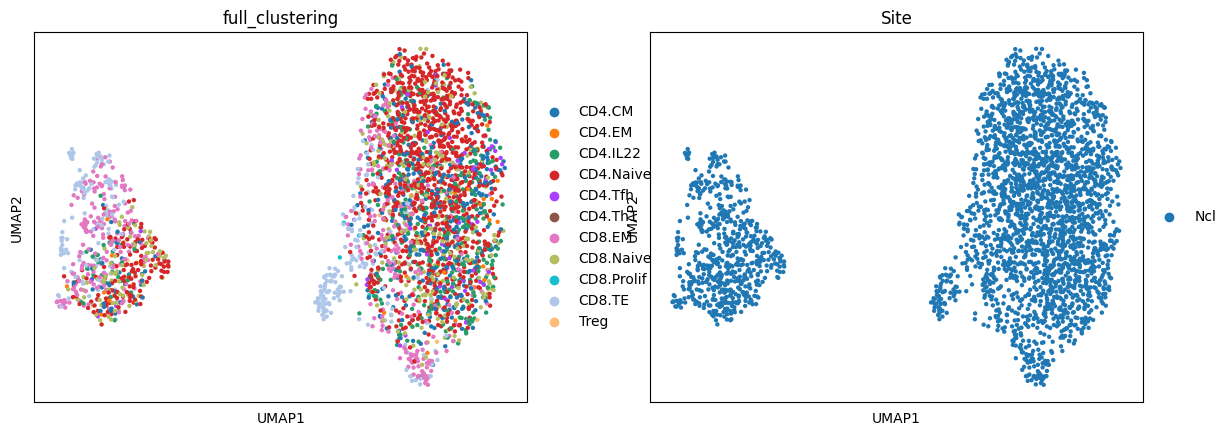

In [9]:
sc.pp.neighbors(latent_moe, use_rep='X')
sc.tl.umap(latent_moe)
sc.pl.umap(latent_moe, color=['full_clustering', 'Site'])

Note, that the results here show severe batch-effect and bad conservence of cell type. This is due to the limited amount of patients used, the low amount of epochs per training, and the limited runs for HPO. However, these values where choosen in order to have  short computation times for this tutorial.